In [63]:
# некий фича инжениринг и результат чуть выше бейсланового


In [4]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

<b>1. Делаем вектор верных ответов для трейна. По условию это те, кто набрал более 40 баллов</b>

In [5]:
# можно по сабмитнам просто получить вектор ответов для трейна, так и сделаем, отдельно 
# но! теоретически на 1 степ он мог дать много положительных ответов (перерешивал), поэтому 
# 40 корректных ответов еще не 40 баллов 
df_sub = pd.read_csv('submissions_data_train.zip')
df = df_sub[df_sub['submission_status'] == 'correct']\
       .groupby(['user_id','step_id'], as_index=False)\
       .agg({'timestamp':'count'})\
       .query("timestamp > 1")
# то есть они есть. не много, но есть. 
df.head()

,user_id,step_id,timestamp
46,16,31978,2
204,30,31976,2
207,30,31979,2
208,30,31981,2
209,30,31983,2


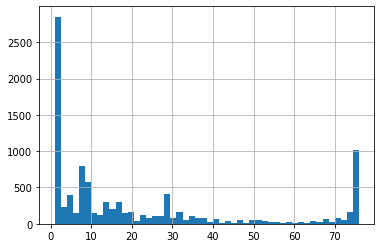

In [6]:
df = df_sub[df_sub['submission_status'] == 'correct']\
       .groupby(['user_id','step_id'], as_index=False)\
       .agg({'timestamp':'count'})\
       .groupby('user_id', as_index=False)\
       .count()
points = df.rename(columns = {'step_id':'points'}).drop(['timestamp'], axis=1)
points['points'].hist(bins=50)

# в points теперь все юзеры у которых ненулевые баллы за решение

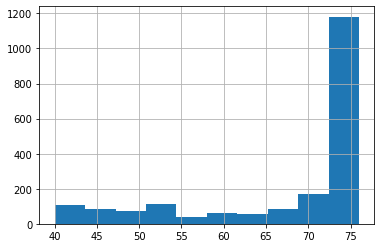

In [7]:
winners = points[points['points'] >= 40]
winners['points'].hist()

<b>2. Нужно причесать все данные в большой датасет. Чтобы правильно учиться, нужно отсечь все только за первые двое суток обучения. Т.е оба датасета нужно "подстричь", оставить данные по юзерам за первые 24 часа</b>

In [8]:
timedelta = 24*2*3600

In [9]:
df_ev = pd.read_csv('event_data_train.zip')
print(df_ev.shape)
df_ev.head(2)

(3480703, 4)


,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632


In [10]:
df_ts = df_ev.groupby(['user_id'], as_index=False).agg({'timestamp':'min'})
df_ts['timestamp'] = df_ts['timestamp'] + timedelta

df_events = pd.merge(df_ev, df_ts, left_on='user_id', right_on='user_id', 
                     how='left')

# теперь убиваем все где timestamp_y > timestamp_x
df_ev_48 = df_events[df_events['timestamp_x'] <= df_events['timestamp_y']]\
                .drop(['timestamp_y'], axis=1)\
                .rename(columns={'timestamp_x':'timestamp'})
print(df_ev_48.shape)
df_ev_48.head()

(906203, 4)


,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


<b>первый подрезали, теперь второй</b>

In [11]:
df_sub = pd.read_csv('submissions_data_train.zip')
print(df_sub.shape)
df_sub.head(2)

(509104, 4)


,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853


In [12]:
df_submits = pd.merge(df_sub, df_ts, left_on='user_id', right_on='user_id', 
                     how='left')
df_sub_48 = df_submits[df_submits['timestamp_x'] <= df_submits['timestamp_y']]\
                .drop(['timestamp_y'], axis=1)\
                .rename(columns={'timestamp_x':'timestamp'})
print(df_sub_48.shape)
df_sub_48.head()

(115466, 4)


,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
7,31977,1434347371,correct,15853


<b>3. Теперь фича инжениринг. Есть 3 датасета</b>

winners - те юзерайди у которых больша 40 поинтов<br>
points - сколько поинтов набрано за первые 2 дня<br>
df_sub_48 - сабмиты за первые 24 часа<br>
df_ev_48 - события за первые 24 часа<br>

In [13]:
df_ev_48['date'] = pd.to_datetime(df_ev_48['timestamp'], unit='s').dt.date
df_ev_48.head(3)
# можно считать среднее время в сутки которое он решал, но на 2 сут это будет фонить из-за 
# перехлеста через полночь
#
# day_duration = df_ev_48.groupby(['user_id', 'date'], as_index=False).agg({'timestamp': ['min','max']})
# day_duration['length'] = day_duration[('timestamp','max')] - day_duration[('timestamp','min')]

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15


In [14]:
#df_ev_48['date'] = pd.to_datetime(df_ev_48['timestamp'], unit='s').dt.date
#day_duration = df_ev_48.groupby(['user_id', 'date'], as_index=False).agg({'timestamp': ['min','max']})

# продолжительность занятия посхитали, по сути больше не нужен таймстемп, но .... 
#df_ev = df_ev.drop(['step_id', 'timestamp'],axis=1)

# day_dyration['length'] - время которое занимался в день. Тоже признак
# еще хороший признак доля успешных решений среди всех решений
#day_duration['length'] = day_duration[('timestamp','max')] - day_duration[('timestamp','min')]

In [15]:
df_ev_48l = df_ev_48.drop(['timestamp','date'], axis=1)\
                .pivot_table(columns='action', index='user_id', 
                             values='step_id', aggfunc='count', fill_value=0).reset_index()
df_ev_48l.head(2)

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9


In [16]:
# нам сама дата-то эта и не нужна - чисто так
df_sub_48l = df_sub_48.drop(['timestamp'], axis=1)\
                .pivot_table(columns='submission_status', index='user_id',
                             values='step_id', aggfunc='count', fill_value=0)\
                .reset_index()
df_sub_48l.head(2) 

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4


<b>Смерджим и приделаем колонку ответов</b>

In [17]:
df_train = pd.merge(df_ev_48l, df_sub_48l, left_on='user_id', right_on='user_id', how='outer').fillna(0)
df_train.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,9,2.0,0.0
2,3,15,15,4,20,4.0,4.0
3,5,1,1,0,1,0.0,0.0
4,7,1,1,0,1,0.0,0.0


In [18]:
winners['y'] = 1

/home/sda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
winners.head()

,user_id,points,y
4,16,76,1
5,22,76,1
8,30,76,1
11,34,73,1
13,39,76,1


In [20]:
y = winners[['user_id','y']]
y.head()

,user_id,y
4,16,1
5,22,1
8,30,1
11,34,1
13,39,1


In [22]:
df_full = pd.merge(df_train, y, left_on='user_id', right_on='user_id', how="left").fillna(0)
df_full.head(20)

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,y
0,1,1,0,0,1,0.0,0.0,0.0
1,2,9,9,2,9,2.0,0.0,0.0
2,3,15,15,4,20,4.0,4.0,0.0
3,5,1,1,0,1,0.0,0.0,0.0
4,7,1,1,0,1,0.0,0.0,0.0
5,8,109,84,37,154,9.0,21.0,0.0
6,9,3,3,0,4,0.0,0.0,0.0
7,11,1,0,1,1,0.0,0.0,0.0
8,14,4,3,1,9,0.0,1.0,0.0
9,16,50,49,21,117,18.0,23.0,1.0


<b>Все, в каком-то виде трейн готов! можно учить модельки</b>

In [26]:
rf = RandomForestClassifier()

params = {'n_estimators': [20,100],
          'max_depth': [3,4,5],
          'min_samples_split': [2,10],
          'min_samples_leaf': [1,10]}
    
search = GridSearchCV(rf, params, cv = 5)
search.fit(df_full.iloc[:,:-1], df_full.iloc[:,-1])

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [27]:
search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

In [28]:
clf = search.best_estimator_

<b>Готовим тестовые датасеты</b>

In [58]:
df_ev_test = pd.read_csv('events_data_test.csv')

df_ev_test_l = df_ev_test.drop(['timestamp'], axis=1)\
                .pivot_table(columns='action', index='user_id', 
                             values='step_id', aggfunc='count', fill_value=0).reset_index()
df_ev_test_l.head(2)

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1


In [59]:
df_sub_test = pd.read_csv('submission_data_test.csv')

df_sub_test_l = df_sub_test.drop(['timestamp'], axis=1)\
                .pivot_table(columns='submission_status', index='user_id',
                             values='step_id', aggfunc='count', fill_value=0)\
                .reset_index()
df_sub_test_l.head(2) 



submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36


In [60]:
df_test = pd.merge(df_ev_test_l, df_sub_test_l, left_on='user_id', right_on='user_id', how='outer').fillna(0)
df_test.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,4,1,1,0,1,0.0,0.0
1,6,1,1,0,1,0.0,0.0
2,10,2,2,0,6,0.0,0.0
3,12,11,9,4,14,1.0,0.0
4,13,70,70,35,105,29.0,36.0


<b>Выгрузка данных</b>

In [61]:
res = clf.predict_proba(df_test)
res.shape

(6184, 2)

In [62]:
res_df = df_test[['user_id']]
res_df['is_gone'] = res[:,1]
res_df.to_csv('result.csv', index=False)

/home/sda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


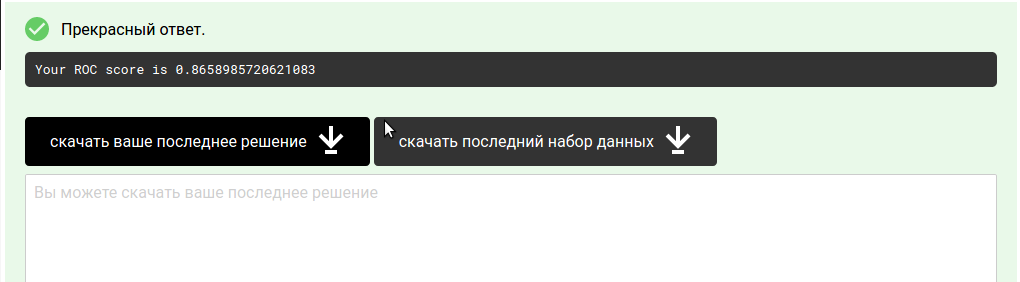